# 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Set random seed for reproducibility
np.random.seed(42)


# Import additional libraries for hyperparameter tuning
from sklearn.metrics import precision_score, recall_score, classification_report
import optuna
from optuna.samplers import TPESampler

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 2. Load Data set

In [2]:
# Sourcecode found @ https://archive.ics.uci.edu/dataset/186/wine+quality
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

# 3. Data Preparation

<mark style="background-color: #fff000;">Item 1. Split the samples into 70% Training and 30% Testing data at random with stratification 
(stratify=y)</mark>

In [3]:
# Split the dataset into training and testing sets(30% test size, 70% train size), stratified by the target variable
# Split first via color of the wine, then combine both colors after splitting
X_red =  wine_quality.data["original"][wine_quality.data["original"]['color'] == 'red'].drop(columns=['quality', 'color'])
y_red = wine_quality.data["original"][wine_quality.data["original"]['color'] == 'red']['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_red, y_red, test_size=0.3, stratify=y_red, random_state=42
)

X_white =  wine_quality.data["original"][wine_quality.data["original"]['color'] == 'white'].drop(columns=['quality', 'color'])
y_white = wine_quality.data["original"][wine_quality.data["original"]['color'] == 'white']['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(
    X_white, y_white, test_size=0.3, stratify=y_white, random_state=42
)

# Combine the splits
X_train = pd.concat([X_train_red, X_train_white])
y_train = pd.concat([y_train_red, y_train_white])
X_test = pd.concat([X_test_red, X_test_white])
y_test = pd.concat([y_test_red, y_test_white])

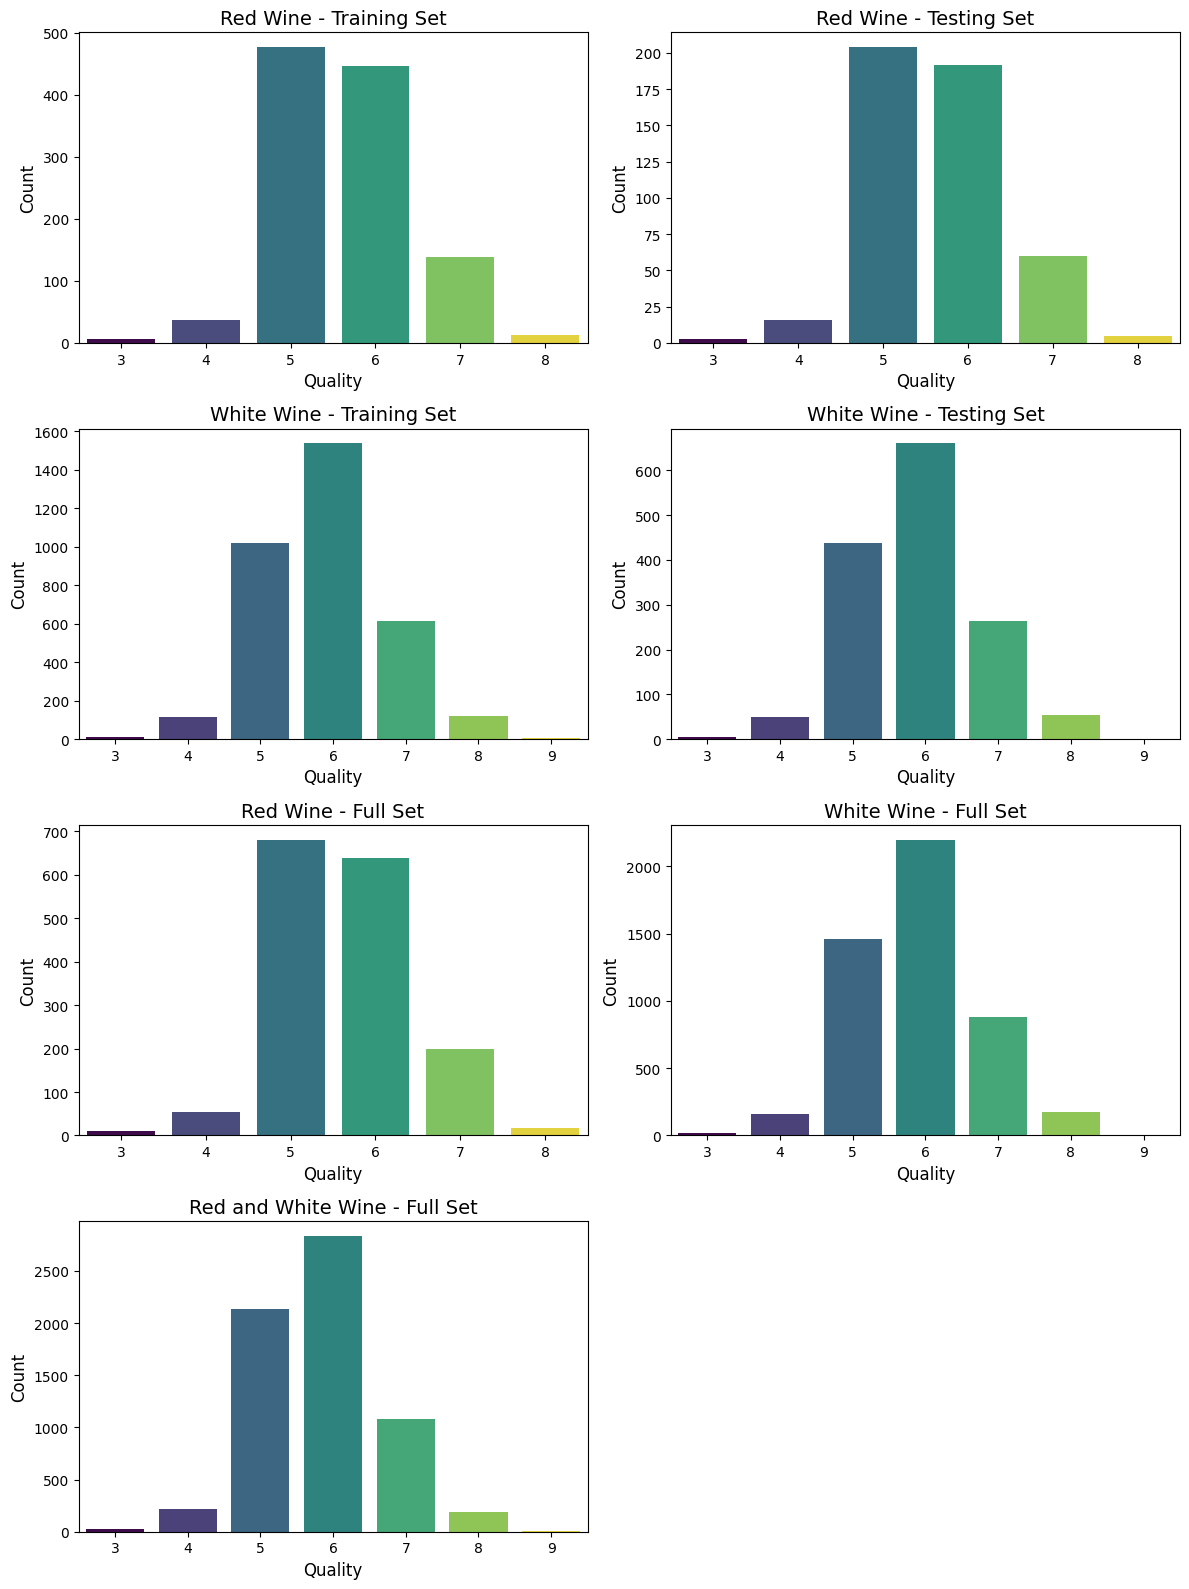

In [4]:
def plot_target_distribution(dataframes, titles):
    """
    Plots the distribution of the target variable for multiple dataframes.

    Parameters:
        dataframes (list of pd.DataFrame): List of dataframes to plot.
        titles (list of str): Corresponding titles for the dataframes.

    Returns:
        None
    """
    num_plots = len(dataframes)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()

    for i, (df, title) in enumerate(zip(dataframes, titles)):
        ax = axes[i]
        sns.countplot(x='quality', data=df, ax=ax, palette='viridis', hue='quality', legend=False)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Quality', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
# Ensure the dataframes contain the 'quality' column
plot_target_distribution(
    [
        pd.DataFrame({'quality': y_train_red}),
        pd.DataFrame({'quality': y_test_red}),
        pd.DataFrame({'quality': y_train_white}),
        pd.DataFrame({'quality': y_test_white}),
        pd.DataFrame({'quality': y_red}),
        pd.DataFrame({'quality': y_white}),
        pd.DataFrame({'quality': pd.concat([y_red, y_white])}) 
    ],
    ["Red Wine - Training Set", "Red Wine - Testing Set", "White Wine - Training Set", "White Wine - Testing Set", "Red Wine - Full Set", "White Wine - Full Set", "Red and White Wine - Full Set"]
)

# 4. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers 


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

## 4.0. Utility Functions


<mark style="background-color: #fff000;">Item 1. Report the accuracy, precision, recall, F1-
score, and confusion matrix of all the models on test data.</mark>

In [33]:

# Prompt: Create a evaluation function that takes in a model, X_test, y_test and returns accuracy, f1-score, precision, recall
def evaluate_model(model, X_test, y_test, red_test=None, white_test=None):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    results = {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
    if red_test is not None:
        x_red_test = red_test['x']
        y_red_test = red_test['y']
        evaluate_model_red = evaluate_model(model, x_red_test, y_red_test)
        results['red_wine'] = evaluate_model_red
    if white_test is not None:
        x_white_test = white_test['x']
        y_white_test = white_test['y']
        evaluate_model_white = evaluate_model(model, x_white_test, y_white_test)
        results['white_wine'] = evaluate_model_white

    return results

# prompt: Create a function that plots the confusion matrix given a data of type list: { y_pred, y_test, model_name }
# function must receive a list of y_pred for multiple models and plot them in a single figure with subplots
def plot_confusion_matrix(data: list[dict]):
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 5))
    if n_models == 1:
        axes = [axes]
    for ax, y_pred, y_test, model_name in zip(axes, data['y_pred'], data['y_test'], data['model_name']):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        ax.set_title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

# prompt: create a function that stores model results in a dictionary, given model name and evaluation metrics
def store_model_results(model_name, evaluation_metrics, results_dict):
    results_dict[model_name] = evaluation_metrics

    
# prompt: create a function that Prints model results, as a table,
# print result of white and red as different table

def print_evaluation_results(evaluation, title):
    print(f"\n{title}")
    print("Model results on Test Data (Overall, Red Wine, White Wine).\n")
    
    # Combine overall, red wine, and white wine results into a single table
    results = pd.DataFrame({
        "Dataset": ["Overall", "Red Wine", "White Wine"],
        "Accuracy": [
            evaluation.get("accuracy"),
            evaluation.get("red_wine", {}).get("accuracy"),
            evaluation.get("white_wine", {}).get("accuracy")
        ],
        "F1-Score": [
            evaluation.get("f1"),
            evaluation.get("red_wine", {}).get("f1"),
            evaluation.get("white_wine", {}).get("f1")
        ],
        "Precision": [
            evaluation.get("precision"),
            evaluation.get("red_wine", {}).get("precision"),
            evaluation.get("white_wine", {}).get("precision")
        ],
        "Recall": [
            evaluation.get("recall"),
            evaluation.get("red_wine", {}).get("recall"),
            evaluation.get("white_wine", {}).get("recall")
        ]
    })
    
    print("=" * 50)
    # Print the combined table
    print(results.to_string(index=False))
    print("=" * 50)

## 4.I. Build, Train, and Evaluate <mark style="background-color: #fff000;"> SVM classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [9]:

def objective_svm(trial):
    """Optuna objective function for RBF kernel SVM"""
    # Suggest hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 1.0, log=True)
    
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, C=C, gamma=gamma,  random_state=42))
    ])
    
    # Train and evaluate
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_test)
    
    # Return F1-macro score (maximize)
    return f1_score(y_test, y_val_pred, average='macro')

# Create study and optimize
print("Optimizing SVM with Optuna...")
study_svm = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study_svm.optimize(objective_svm, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params_svm = study_svm.best_params
print(f"\nBest parameters for RBF SVM:")
print(f"  Kernel: {best_params_svm['kernel']}")
print(f"  C: {best_params_svm['C']:.4f}")
print(f"  gamma: {best_params_svm['gamma']:.4f}")



Optimizing SVM with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]


Best parameters for RBF SVM:
  Kernel: rbf
  C: 29.8397
  gamma: 0.7386



SVM Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.628205  0.620901   0.622962 0.628205
  Red Wine  0.635417  0.625668   0.632771 0.635417
White Wine  0.625850  0.619218   0.620294 0.625850


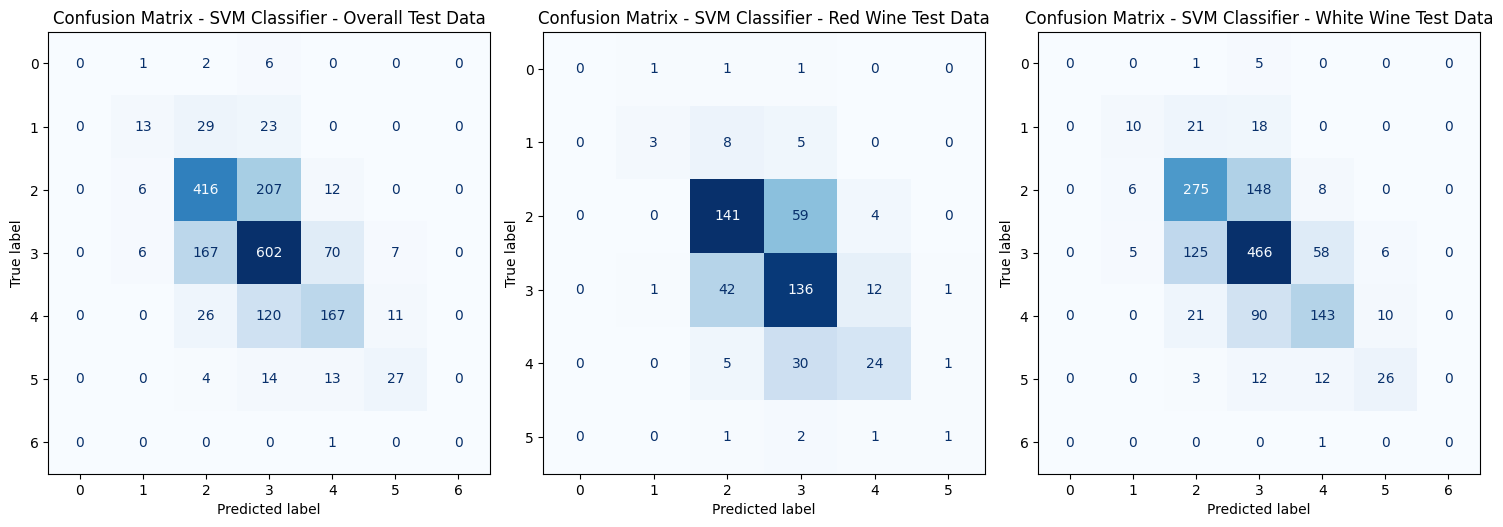

In [36]:
# Train model with best parameters
optimized_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel=best_params_svm['kernel'],
        C=best_params_svm['C'],
        gamma=best_params_svm['gamma'],
        coef0=best_params_svm.get('coef0', 0.0),
        degree=best_params_svm.get('degree', 3),
        random_state=42
    ))
])

# Fit the optimized model
optimized_svm.fit(X_train, y_train)
# Evaluate
optimized_svm_result = evaluate_model(
    optimized_svm,
    X_test, y_test, red_test={"x": X_test_red, "y": y_test_red}, white_test={
        "x": X_test_white, "y": y_test_white
    }
)
print_evaluation_results(optimized_svm_result, title="SVM Classifier")
plot_confusion_matrix({
    'y_pred': [optimized_svm.predict(X_test), optimized_svm.predict(X_test_red), optimized_svm.predict(X_test_white)],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["SVM Classifier - Overall Test Data", "SVM Classifier - Red Wine Test Data", "SVM Classifier - White Wine Test Data"]
})

## 4.II. Build, Train, and Evaluate <mark style="background-color: #fff000;"> MLP classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [37]:
# Sourcecode adapted from AI221 repo: 
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.stats import randint, loguniform
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model_params = {'alpha': loguniform(1e-4, 10),
                'solver': ['sgd','adam'],
                'hidden_layer_sizes': randint(4,16),
                'activation': ['identity','logistic','tanh','relu']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_iter = 50
optimized_mlp = RandomizedSearchCV(MLPClassifier(max_iter=5000), cv=cv,
                                   param_distributions=model_params, 
                                   n_iter=n_iter, verbose=1)

start = time()
optimized_mlp.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

# Print best parameters after tuning
print(optimized_mlp.best_params_)
  
# Print how our model looks after hyper-parameter tuning
print(optimized_mlp.best_estimator_)


Fitting 15 folds for each of 50 candidates, totalling 750 fits


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV took 454.52 seconds for 50 candidates parameter settings.
{'activation': 'logistic', 'alpha': np.float64(0.0042258746449961694), 'hidden_layer_sizes': 6, 'solver': 'adam'}
MLPClassifier(activation='logistic', alpha=np.float64(0.0042258746449961694),
              hidden_layer_sizes=6, max_iter=5000)



MLP Classifier
Model results on Test Data (Overall, Red Wine, White Wine).

   Dataset  Accuracy  F1-Score  Precision   Recall
   Overall  0.537949  0.481074   0.506352 0.537949
  Red Wine  0.560417  0.505802   0.461339 0.560417
White Wine  0.530612  0.470492   0.500033 0.530612


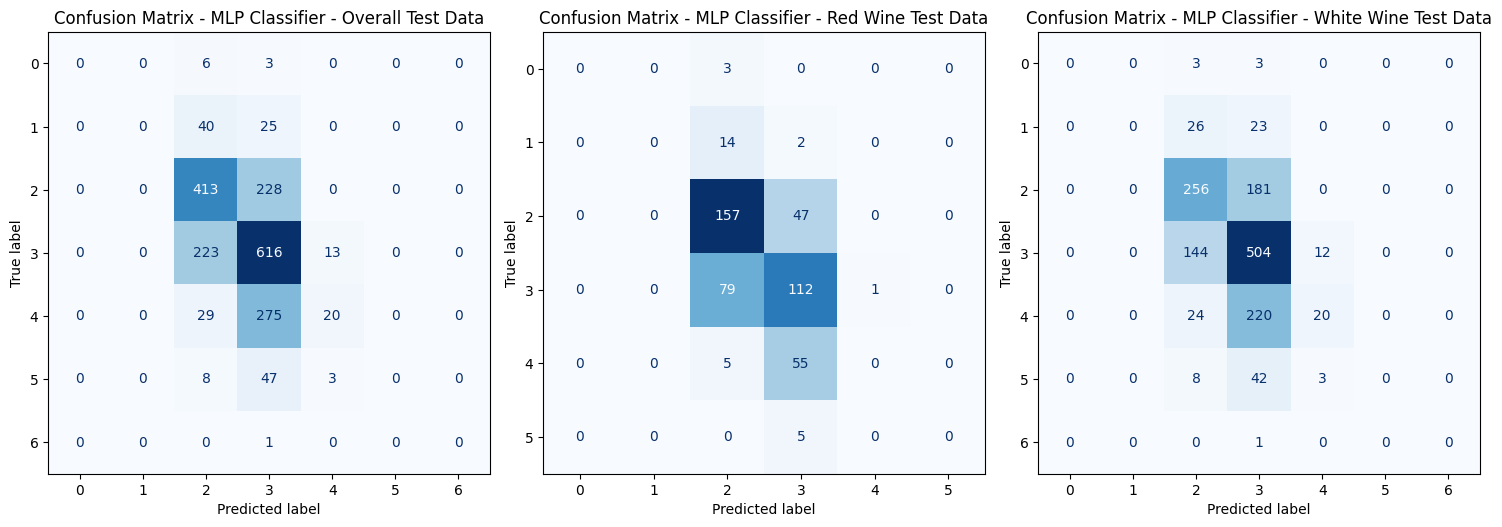

In [ ]:

y = optimized_mlp.predict(X_test)

optimized_mlp_result = evaluate_model(
    optimized_mlp,
    X_test, y_test, red_test={"x": X_test_red, "y": y_test_red}, white_test={
        "x": X_test_white, "y": y_test_white
    }
)

print_evaluation_results(optimized_mlp_result, title="MLP Classifier")
plot_confusion_matrix({
    'y_pred': [optimized_mlp.predict(X_test), optimized_mlp.predict(X_test_red), optimized_mlp.predict(X_test_white)],
    'y_test': [y_test, y_test_red, y_test_white],
    'model_name': ["MLP Classifier - Overall Test Data", "MLP Classifier - Red Wine Test Data", "MLP Classifier - White Wine Test Data"]
})

## 4.III. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Random Forest classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

Optimizing Linear SVM with Optuna...


Optimizing Linear SVM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

Optimizing Linear SVM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConve

Optimizing Linear SVM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConve


Best parameters for Linear SVM:
  C: 0.0421
  Best F1-macro score: 0.1669


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimizing Linear SVM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConve


Best parameters for Linear SVM:
  C: 0.0421
  Best F1-macro score: 0.1669


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== Optuna-Optimized Linear SVM ===
Training Accuracy: 0.5365 (53.65%)
Testing Accuracy: 0.5188 (51.88%)
Training F1-macro: 0.1733
Testing F1-macro: 0.1669
Precision (macro): 0.1528
Recall (macro): 0.1896
--------------------------------------------------


c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 4.IV. Build, Train, and Evaluate <mark style="background-color: #fff000;"> Gradient Boosting classifier </mark>


<mark style="background-color: #fff000;">Item 1. Train SVM, MLP, Random Forest, and Gradient Boosting classifiers on the data. 
You are free to do your own hyper-parameter tuning.</mark>

In [ ]:

import xgboost as xgb


# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {"objective": "multi:softprob", "num_class": 5}
n = 1000

# XGBoost with cross-validation is used
results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["mlogloss", "auc", "merror"]
)

Optimizing Polynomial SVM with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhon\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConve

# 5. Train SVR, MLP, Random Forest, and Gradient Boosting regressors


<mark style="background-color: #fff000;">Item b. Use SVR, MLP, Random Forest, and Gradient Boosting regressors</mark>

## 5.0. Utility functions


<mark style="background-color: #fff000;">Item b. <mark style="background-color: #fff000;">Item b. Report the MSE, R2, and MAD (mean absolute) on test data.</mark>

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------
# Evaluate a regression model (returns MSE, R2, MAE)
# --------------------------------------------------------
def evaluate_regression_model(model, X_test, y_test, red_test=None, white_test=None):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results = {
        "mse": mse,
        "r2": r2,
        "mae": mae,
    }

    # Optional: evaluate on red and white test sets if provided
    if red_test is not None:
        x_red_test = red_test['x']
        y_red_test = red_test['y']
        evaluate_red = evaluate_regression_model(model, x_red_test, y_red_test)
        results['red_wine'] = evaluate_red

    if white_test is not None:
        x_white_test = white_test['x']
        y_white_test = white_test['y']
        evaluate_white = evaluate_regression_model(model, x_white_test, y_white_test)
        results['white_wine'] = evaluate_white

    return results


# --------------------------------------------------------
# Plot regression residual plots for multiple models
# --------------------------------------------------------
def plot_regression_residuals(data):
    """
    data: dict with keys ['y_pred', 'y_test', 'model_name'], each containing lists for multiple models
    Example:
        data = {
            'y_pred': [y_pred_lr, y_pred_rf],
            'y_test': [y_test, y_test],
            'model_name': ['Linear Regression', 'Random Forest']
        }
    """
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 6, 5))

    if n_models == 1:
        axes = [axes]

    for i, (y_pred, y_test, model_name) in enumerate(
        zip(data['y_pred'], data['y_test'], data['model_name'])
    ):
        residuals = y_test - y_pred
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[i])
        axes[i].axhline(0, color='red', linestyle='--')
        axes[i].set_title(f"Residual Plot - {model_name}")
        axes[i].set_xlabel("Predicted Values")
        axes[i].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()


def plot_actual_vs_predicted(data):
    """
    Plots Actual vs Predicted scatter plots for multiple regression models.

    Parameters
    ----------
    data : dict
        Must contain:
            - 'y_pred': list of model predictions
            - 'y_test': list of corresponding true values
            - 'model_name': list of model names (same length as above)
        Example:
            data = {
                'y_pred': [y_pred_lr, y_pred_rf],
                'y_test': [y_test, y_test],
                'model_name': ['Linear Regression', 'Random Forest']
            }
    """
    n_models = len(data['model_name'])
    fig, axes = plt.subplots(1, n_models, figsize=(n_models * 6, 5))

    if n_models == 1:
        axes = [axes]

    for i, (y_pred, y_test, model_name) in enumerate(
        zip(data['y_pred'], data['y_test'], data['model_name'])
    ):
        sns.scatterplot(x=y_test, y=y_pred, ax=axes[i])
        # Plot ideal line y = x
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[i].set_title(f"Actual vs Predicted - {model_name}")
        axes[i].set_xlabel("Actual Values")
        axes[i].set_ylabel("Predicted Values")
        axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    
# --------------------------------------------------------
# Store model results in a dictionary
# --------------------------------------------------------
def store_regression_results(model_name, evaluation_metrics, results_dict):
    results_dict[model_name] = evaluation_metrics


# --------------------------------------------------------
# Print evaluation results
# --------------------------------------------------------
def print_regression_results(evaluation, title):
    print(f"\n{title}")
    print(f"MSE: {evaluation['mse']:.4f}")
    print(f"R²: {evaluation['r2']:.4f}")
    print(f"MAE: {evaluation['mae']:.4f}")


# 6. Further Answers:


<mark style="background-color: #fff000;">Item b. Were you able to improve against the result in the paper? </mark>

The overall accuracies reported in the paper are 62.4% (red) and 64.6% (white). 

The best model produced an accurary of 


<mark style="background-color: #fff000;">Item b. Based on your results, discuss the difference of treating this problem as classification or regression. How will this decision impact the users of your model?</mark>

Original Paper: 
https://www.sciencedirect.com/science/article/pii/S0167923609001377



In [ ]:
# Display an image
idisplay(Image(filename=image_path))
mage_path = "patAI2a\wi/e_manu_table2.1png# Replace with your image path
didisplay(Image(filename=image_path))
splay(Image(filename=image_path))# Get best model
best_model_name = best_test_f1[0]
best_model_results = best_test_f1[1]
best_pipeline = best_model_results['pipeline']

# Make predictions
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

print("=" * 100)
print(f"DETAILED PERFORMANCE REPORT: {best_model_name}")
print("=" * 100)

# Training data metrics
print("\n📊 TRAINING DATA METRICS:")
print(f"  Accuracy:  {best_model_results['train_accuracy']:.4f} ({best_model_results['train_accuracy']*100:.2f}%)")
print(f"  F1-Score:  {best_model_results['train_f1_macro']:.4f}")

# Testing data metrics
print("\n📊 TESTING DATA METRICS:")
print(f"  Accuracy:   {best_model_results['test_accuracy']:.4f} ({best_model_results['test_accuracy']*100:.2f}%)")
print(f"  Precision:  {best_model_results['test_precision']:.4f}")
print(f"  Recall:     {best_model_results['test_recall']:.4f}")
print(f"  F1-Score:   {best_model_results['test_f1_macro']:.4f}")

# Performance gap
print("\n📈 GENERALIZATION:")
print(f"  Accuracy Gap: {best_model_results['train_accuracy'] - best_model_results['test_accuracy']:.4f}")
print(f"  F1-Score Gap: {best_model_results['train_f1_macro'] - best_model_results['test_f1_macro']:.4f}")

# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT (Test Data):")
print(classification_report(y_test, y_test_pred))

# 7. Confusion Matrices

Visualize confusion matrices for training and testing data.

In [ ]:
# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training data confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=best_pipeline['svm'].classes_
)
disp_train.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title(f'Training Data Confusion Matrix\n{best_model_name}', fontsize=14, pad=20)
ax1.grid(False)

# Testing data confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=best_pipeline['svm'].classes_
)
disp_test.plot(ax=ax2, cmap='Oranges', values_format='d')
ax2.set_title(f'Testing Data Confusion Matrix\n{best_model_name}', fontsize=14, pad=20)
ax2.grid(False)

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print("• Diagonal elements represent correct predictions")
print("• Off-diagonal elements represent misclassifications")
print(f"• Training samples: {len(y_train)}")
print(f"• Testing samples: {len(y_test)}")

## 8. Optuna Optimization History

Visualize the optimization history to understand how Optuna found the best parameters.